In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [40]:
'''
reading a csv file and storing it in pandas dataframe df
.head() function will print the first 5 rows
'''
df=pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


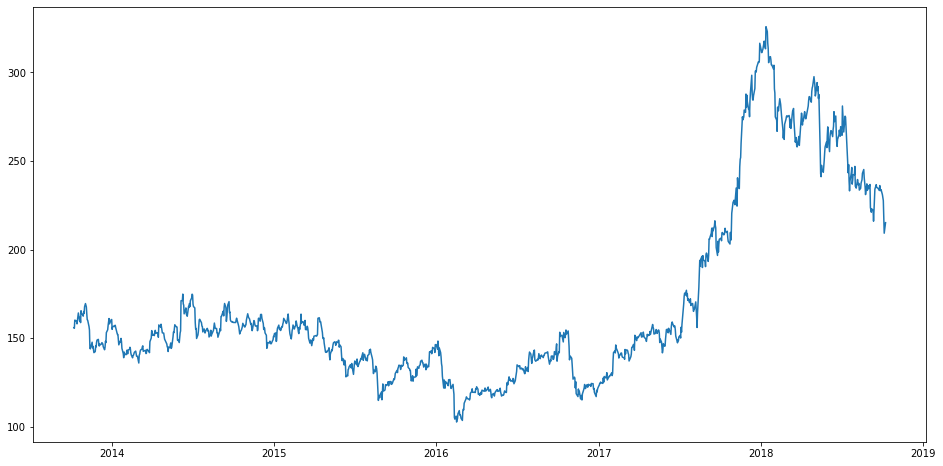

In [41]:
'''
Converting the "Date" column to datetime object of the format
"YYYY-MM-DD" and then we are indexing the dataframe with the 
date column
'''
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [42]:
'''
sorting the index, which is date, in ascending order
Creating a new_dataset with the two columns "Date" and "Close"
and copying the "Date" and "Close" columns from data, dataframe
'''

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [43]:
'''
Splitting the dataset into train and validation datasets
setting the "Date" column as the index and scaling the "Close"
column between 0 and 1. Then I create the x_train_data which contains
previous past 60 closing prices as input and the next closing price 
as y_train_data.
'''

scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [45]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)

Epoch 1/10


C:\Users\asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


927/927 - 13s - loss: 0.0011 - 13s/epoch - 14ms/step
Epoch 2/10
927/927 - 11s - loss: 4.8282e-04 - 11s/epoch - 11ms/step
Epoch 3/10
927/927 - 11s - loss: 3.5573e-04 - 11s/epoch - 12ms/step
Epoch 4/10
927/927 - 11s - loss: 3.0995e-04 - 11s/epoch - 11ms/step
Epoch 5/10
927/927 - 11s - loss: 2.8614e-04 - 11s/epoch - 11ms/step
Epoch 6/10
927/927 - 11s - loss: 2.5063e-04 - 11s/epoch - 11ms/step
Epoch 7/10
927/927 - 11s - loss: 2.5211e-04 - 11s/epoch - 12ms/step
Epoch 8/10
927/927 - 11s - loss: 2.3095e-04 - 11s/epoch - 12ms/step
Epoch 9/10
927/927 - 11s - loss: 2.5674e-04 - 11s/epoch - 12ms/step
Epoch 10/10
927/927 - 11s - loss: 2.2946e-04 - 11s/epoch - 12ms/step


In [46]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 4s 31ms/step


In [47]:
lstm_model.save("saved_model.h5")

C:\Users\asus\AppData\Local\Temp\ipykernel_43148\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


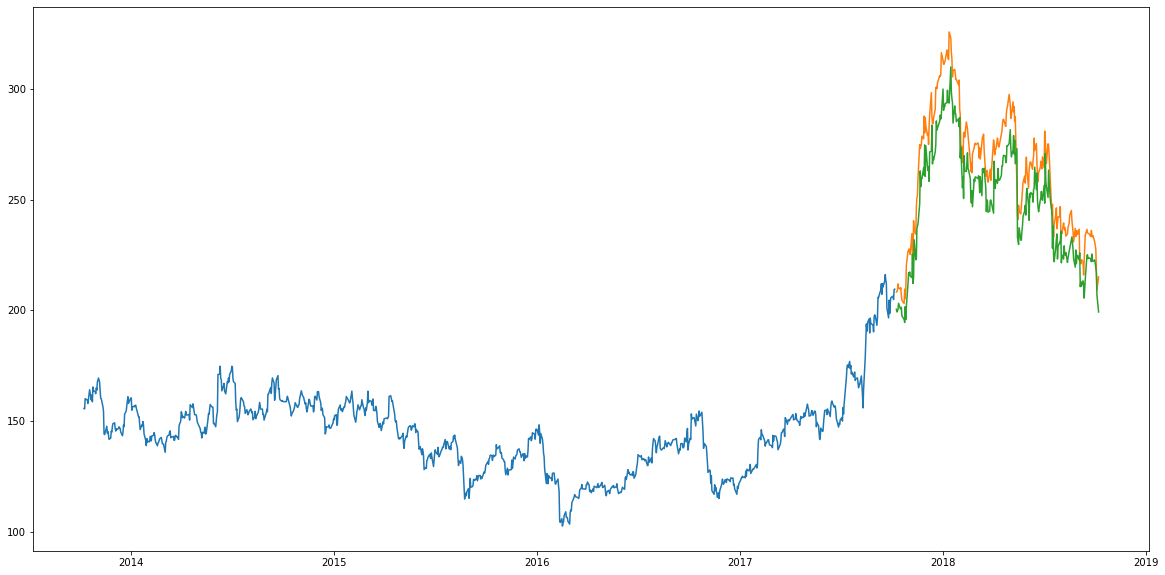

In [48]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])